# Shooting charts from basketball-reference.com

This exercise was inspired by the work of Kirk Goldsberry: https://www.kirkgoldsberry.com/

Parse the whole HTML code of the page, then extract the coordinates of the shots one by one:

In [7]:
# get the html:
from urllib.request import urlopen
html = urlopen("https://www.basketball-reference.com/players/c/curryst01/shooting/2016").read()



# turn the block of code into a table:
full_table = []

for line in str(html).split('<div class="shot-area">')[1].split('<div'):
    if 'style="top:' in line:
        top = int(line.split('top:')[1].split('px')[0])
        left = int(line.split('left:')[1].split('px')[0])
        game = line.split('tip="')[1].split('<br>')[0]
        clock = line.split('<br>')[1].split('<br>')[0]
        description = line.split('<br>')[2]
        score = line.split('<br>')[3].split('"')[0]
        made = 1
        if 'tooltip miss' in line:
            made = 0
        #print(line)
        #print(top,left,game,clock,description,score)
        full_table.append( [top,left,game,clock,description,score,made] )
        

In [8]:
import pandas as pd

df = pd.DataFrame(full_table,
                  columns='top,left,game,clock,description,score,made'.split(','))


df.dtypes

top             int64
left            int64
game           object
clock          object
description    object
score          object
made            int64
dtype: object

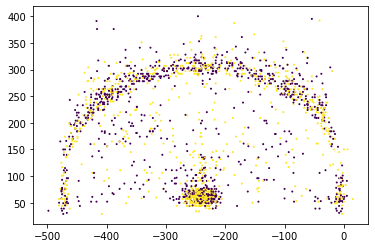

In [9]:
import matplotlib.pyplot as plt
plt.scatter( -1*df['left'] , df['top'] , c=df['made'] ,s=1 )

I copied the code to draw the court lines from this notebook: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb

(-251.0, 251.0, -47.0, 423.0)

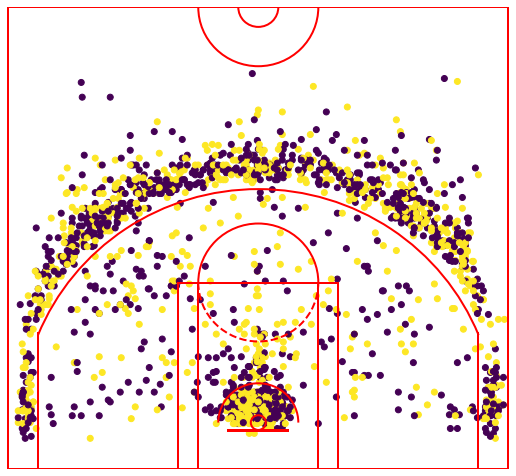

In [10]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(9,8.5))
draw_court(outer_lines=True, color="red")
plt.xlim(-251,251)
plt.ylim(-47,423)

X = -1*df['left'] + 240
Y = df['top'] - 45
plt.scatter( X , Y , c=df['made']  )
plt.axis('off')

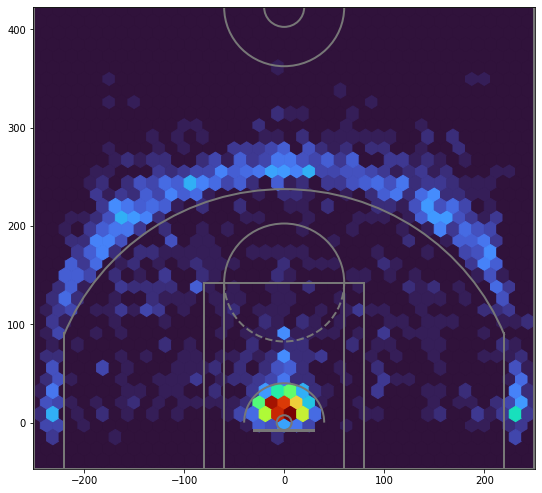

In [11]:
plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
#plt.axis('off')
#plt.xticks([])
#plt.yticks([])
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='turbo',
               extent=(-250,250,-50,420))


# Manipulating the hexbin

First, I want to scale the size of the tiles to the total number of counts.

In [12]:
total_count = hb.get_array()
print( total_count ) # total number in each bin
print( max(total_count) )

# convert the number to size:
new_size = 0.05*total_count
new_size[ new_size>0.7 ] = 0.7

[0. 0. 0. ... 0. 0. 0.]
56.0


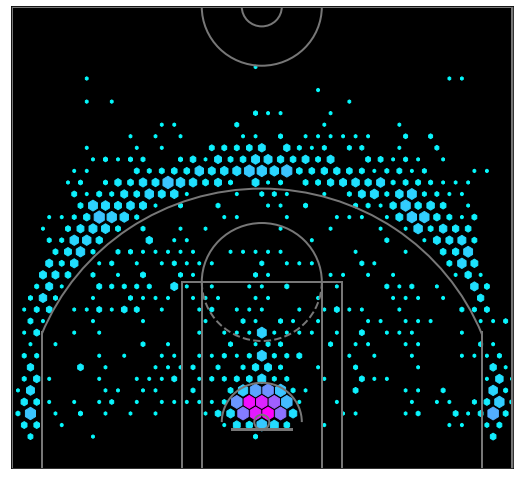

In [13]:
plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.xticks([]); plt.yticks([])
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420),
               sizes=new_size)

Now I want control over the colour. We first compute % in each bin, then replot the whole thing using this value as hard-coded colour.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(-230, 390, 'Stephen Curry - 2015-16')

<Figure size 432x288 with 0 Axes>

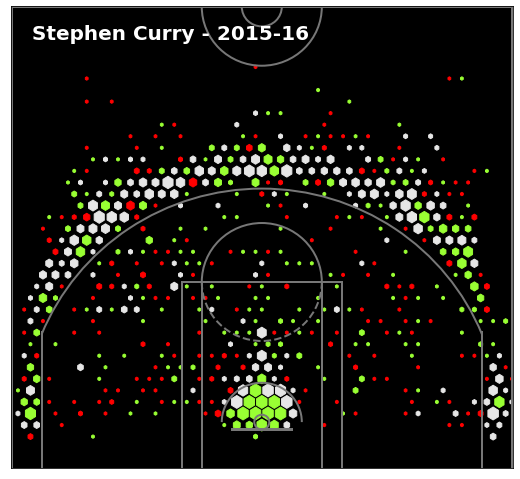

In [14]:
hbMade = plt.hexbin(X[ df['made']==1 ], Y[ df['made']==1 ], gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420) )
hbMissed = plt.hexbin(X[ df['made']==0 ], Y[ df['made']==0 ], gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420) )

plt.clf() # to flush the two plots we just made: we only wanted to catch the output
pctMade = hbMade.get_array() / (hbMade.get_array() + hbMissed.get_array())

# Now convert these numbers to colours:
import numpy as np
pctMade[ np.isnan(pctMade) ] = 0




# Replot:
plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.xticks([]); plt.yticks([])
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420),
               sizes=new_size)

ax = plt.gca()
ax.figure.canvas.draw()
# Now iterate over bins to change their colours:
fcolors = hb.get_facecolors()
for iii in range(len(fcolors)):
    if pctMade[iii] < 0.1:
        fcolors[iii] = [1., 0., 0., 1.]
    elif pctMade[iii] > 0.5:
        fcolors[iii] = [0.6, 1., 0.2, 1.]
    else:
        fcolors[iii] = [0.9, 0.9, 0.9, 1.]        
hb.set(array=None, facecolors=fcolors)

plt.text(-230,390,'Stephen Curry - 2015-16',color='w',fontsize=20,fontweight='bold')

Or use a color map:

[None, None]

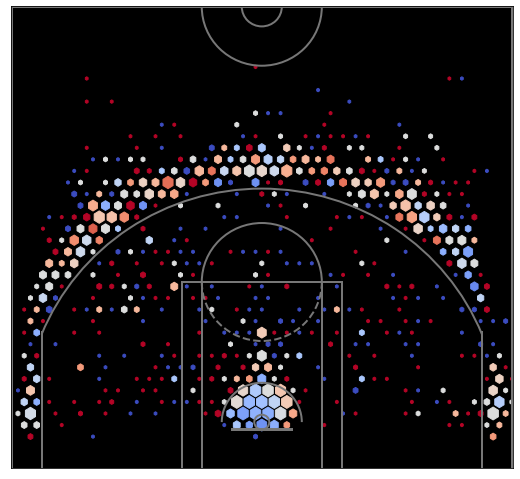

In [15]:
# Replot:
plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.xticks([]); plt.yticks([])
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420),
               sizes=new_size)

ax = plt.gca()
ax.figure.canvas.draw()
# Now iterate over bins to change their colours:
fcolors = hb.get_facecolors()
for iii in range(len(fcolors)):
        fcolors[iii] = plt.get_cmap('coolwarm_r')( pctMade[iii] )     
hb.set(array=None, facecolors=fcolors)

# James Harden

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Text(-230, 390, 'James Harden - 2018-19')

<Figure size 432x288 with 0 Axes>

<Figure size 648x612 with 0 Axes>

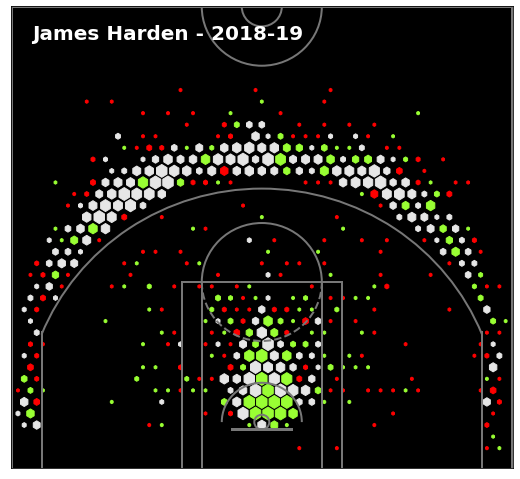

In [16]:
# get the html:
from urllib.request import urlopen
html = urlopen("https://www.basketball-reference.com/players/h/hardeja01/shooting/2019").read()



# turn the block of code into a table:
full_table = []

for line in str(html).split('<div class="shot-area">')[1].split('<div'):
    if 'style="top:' in line:
        top = int(line.split('top:')[1].split('px')[0])
        left = int(line.split('left:')[1].split('px')[0])
        game = line.split('tip="')[1].split('<br>')[0]
        clock = line.split('<br>')[1].split('<br>')[0]
        description = line.split('<br>')[2]
        score = line.split('<br>')[3].split('"')[0]
        made = 1
        if 'tooltip miss' in line:
            made = 0
        #print(line)
        #print(top,left,game,clock,description,score)
        full_table.append( [top,left,game,clock,description,score,made] )
        
import pandas as pd
df = pd.DataFrame(full_table,
                  columns='top,left,game,clock,description,score,made'.split(','))

X = -1*df['left'] + 240
Y = df['top'] - 45



hbMade = plt.hexbin(X[ df['made']==1 ], Y[ df['made']==1 ], gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420) )
hbMissed = plt.hexbin(X[ df['made']==0 ], Y[ df['made']==0 ], gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420) )

plt.clf() # to flush the two plots we just made: we only wanted to catch the output
pctMade = hbMade.get_array() / (hbMade.get_array() + hbMissed.get_array())

# Now convert these numbers to colours:
import numpy as np
pctMade[ np.isnan(pctMade) ] = 0


plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='turbo',
               extent=(-250,250,-50,420))
total_count = hb.get_array()
# convert the number to size:
new_size = 0.05*total_count
new_size[ new_size>0.7 ] = 0.7
plt.clf()



# Replot:
plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.xticks([]); plt.yticks([])
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420),
               sizes=new_size)

ax = plt.gca()
ax.figure.canvas.draw()
# Now iterate over bins to change their colours:
fcolors = hb.get_facecolors()
for iii in range(len(fcolors)):
    if pctMade[iii] < 0.1:
        fcolors[iii] = [1., 0., 0., 1.]
    elif pctMade[iii] > 0.5:
        fcolors[iii] = [0.6, 1., 0.2, 1.]
    else:
        fcolors[iii] = [0.9, 0.9, 0.9, 1.]        
hb.set(array=None, facecolors=fcolors)

plt.text(-230,390,'James Harden - 2018-19',color='w',fontsize=20,fontweight='bold')

# Victor Wembanyama

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Text(-230, 390, 'Victor Wembanyama - 2023-24')

<Figure size 432x288 with 0 Axes>

<Figure size 648x612 with 0 Axes>

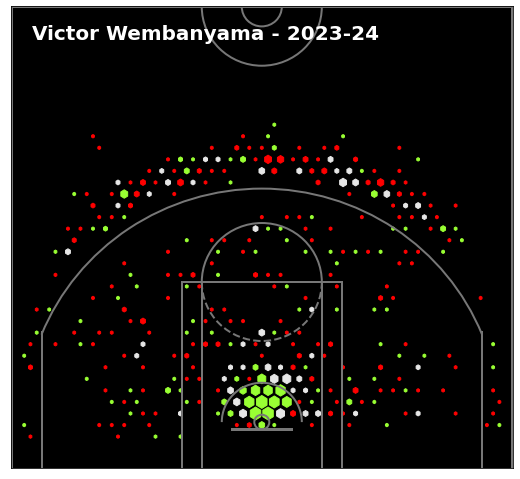

In [18]:
# get the html:
from urllib.request import urlopen
html = urlopen("https://www.basketball-reference.com/players/w/wembavi01/shooting/2024").read()



# turn the block of code into a table:
full_table = []

for line in str(html).split('<div class="shot-area">')[1].split('<div'):
    if 'style="top:' in line:
        top = int(line.split('top:')[1].split('px')[0])
        left = int(line.split('left:')[1].split('px')[0])
        game = line.split('tip="')[1].split('<br>')[0]
        clock = line.split('<br>')[1].split('<br>')[0]
        description = line.split('<br>')[2]
        score = line.split('<br>')[3].split('"')[0]
        made = 1
        if 'tooltip miss' in line:
            made = 0
        #print(line)
        #print(top,left,game,clock,description,score)
        full_table.append( [top,left,game,clock,description,score,made] )
        
import pandas as pd
df = pd.DataFrame(full_table,
                  columns='top,left,game,clock,description,score,made'.split(','))

X = -1*df['left'] + 240
Y = df['top'] - 45



hbMade = plt.hexbin(X[ df['made']==1 ], Y[ df['made']==1 ], gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420) )
hbMissed = plt.hexbin(X[ df['made']==0 ], Y[ df['made']==0 ], gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420) )

plt.clf() # to flush the two plots we just made: we only wanted to catch the output
pctMade = hbMade.get_array() / (hbMade.get_array() + hbMissed.get_array())

# Now convert these numbers to colours:
import numpy as np
pctMade[ np.isnan(pctMade) ] = 0


plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='turbo',
               extent=(-250,250,-50,420))
total_count = hb.get_array()
# convert the number to size:
new_size = 0.05*total_count
new_size[ new_size>0.7 ] = 0.7
plt.clf()



# Replot:
plt.figure(figsize=(9,8.5))
plt.subplot(111,facecolor='k')
draw_court(outer_lines=True, color="#777777")
plt.xlim(-251,251)
plt.ylim(-47,423)
plt.xticks([]); plt.yticks([])
plt.gca().set_facecolor('k')
hb = plt.hexbin(X, Y, gridsize=(40,20), cmap='cool',
               extent=(-250,250,-50,420),
               sizes=new_size)

ax = plt.gca()
ax.figure.canvas.draw()
# Now iterate over bins to change their colours:
fcolors = hb.get_facecolors()
for iii in range(len(fcolors)):
    if pctMade[iii] < 0.1:
        fcolors[iii] = [1., 0., 0., 1.]
    elif pctMade[iii] > 0.5:
        fcolors[iii] = [0.6, 1., 0.2, 1.]
    else:
        fcolors[iii] = [0.9, 0.9, 0.9, 1.]        
hb.set(array=None, facecolors=fcolors)

plt.text(-230,390,'Victor Wembanyama - 2023-24',color='w',fontsize=20,fontweight='bold')